
# Ordinary Least Squares 
# Geographically Weighted Regression
___
- ** New region: Bavaria **
- ** 160 gauges **
- ** Predictors: Elevation, Latitude, Aspect **
- ** Daily rainfall **

In [24]:
library('spatstat')
library('dplyr')
library('sp')
library("raster")
library('RColorBrewer')
library('spgwr')
library('dismo')
# Set some constants
setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Final Project/'))
date_str <- '20170112'
data_file <- paste0('gauge_data/','gauge_data_daily.csv')
data_cols <- c('station_id','date_time','quality',
                 'obs_precip', 'precip_ind','snow','eor')
options(repr.plot.width=6, repr.plot.height=6)

In [25]:
# Read in files and merge
gauge_data <- read.csv(data_file, col.names=data_cols)

meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_metadata <- read.csv('gauge_data/gauge_metadata.csv', col.names=meta_cols)
gauge_data_filtered <- filter(gauge_data, date_time==date_str)
gauges <- merge(gauge_data_filtered, gauge_metadata, by='station_id', all.y=TRUE)
# Make sure to clean out NA or < 0 (unknown values)
gauges <- na.omit(gauges)
gauges <- filter(gauges, obs_precip>=0)
head(gauges)


station_id,date_time,quality,obs_precip,precip_ind,snow,eor,from_date,to_date,elevation,latitude,longitude,stn_name,province
103,20170112,3,11.7,4,6,eor,20040701,20170316,364,48.8960,12.2170,Hagelstadt,Bayern
118,20170112,3,6.6,4,13,eor,20050601,20170316,391,49.4053,12.2852,Altendorf,Bayern
142,20170112,3,8.4,4,4,eor,20051201,20170316,510,48.4060,11.3117,Altomünster-Maisbrunn,Bayern
151,20170112,3,5.6,4,6,eor,20050301,20170316,383,49.4691,11.8546,Amberg-Unterammersricht,Bayern
154,20170112,3,3.8,4,9,eor,20050301,20170316,515,48.0197,12.2924,Amerang-Pfaffing,Bayern
205,20170112,3,8.3,4,36,eor,20050501,20170316,680,47.7274,12.2982,Aschau-Stein,Bayern


### GWR function takes SpatialPointsDataFrame as input

In [26]:
# Prepare SpatialPointsDataFrame
xy_coords <- cbind(gauges$longitude, gauges$latitude) 
proj_wgs84 = CRS("+init=epsg:4326")
coordinates(gauges) <- xy_coords
proj4string(gauges) <- proj_wgs84
# Now gauges should be a SpatialPointsDataFrame
class(gauges)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

### Plot gauge data on map

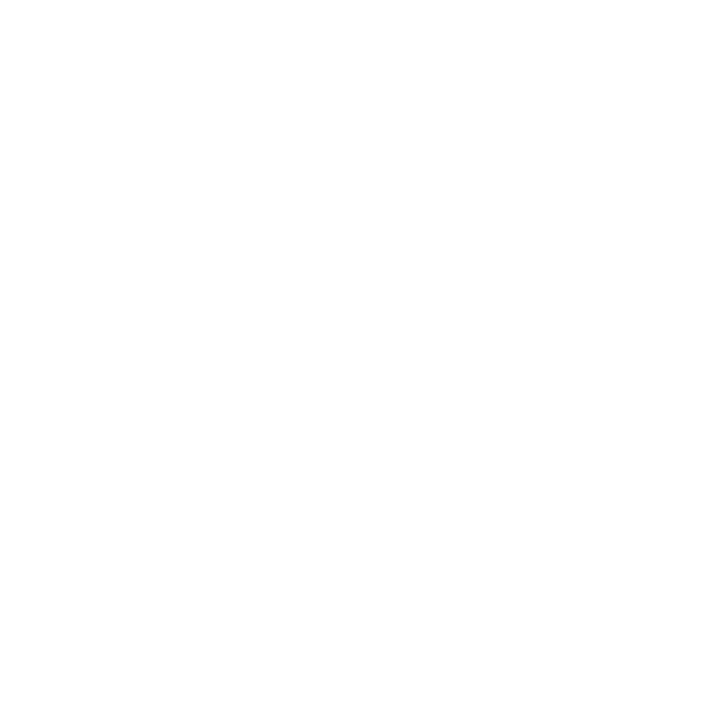

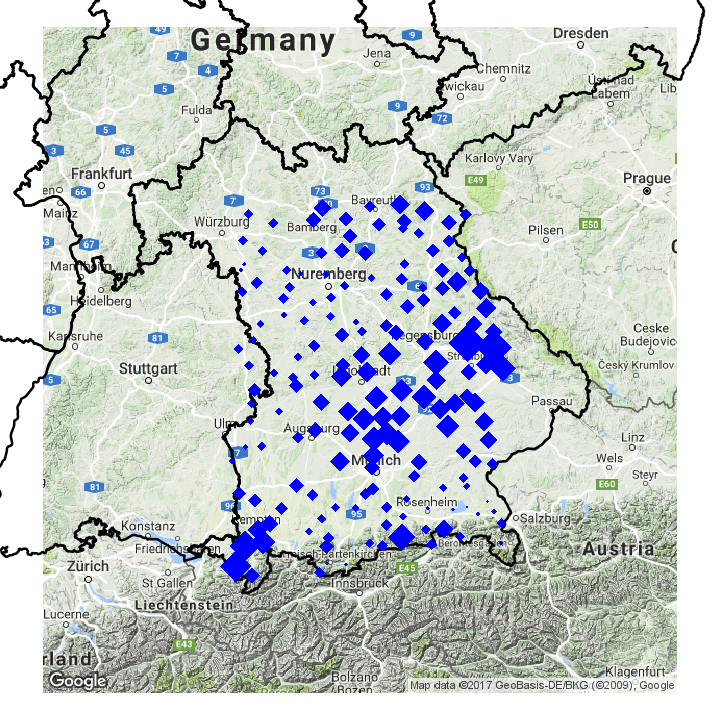

In [27]:
# Show gauges on a map
gadm_1 <- readRDS('GIS/DEU_adm1.rds')
#gadm_2 <- readRDS('GIS/DEU_adm2.rds')
bg <- gmap('Bavaria')
# Reproject gadm borders and gauges to EPSG:3857
gadm_1_reproj <- spTransform(gadm_1, bg@crs)
gauges_reproj <- spTransform(gauges, bg@crs)
plot(bg)
plot(gadm_1_reproj, border='black', lwd=2, add=T)
plot(gauges_reproj, pch=18, col="blue", cex=gauges$obs_precip/4, add=T)

![Bavaria Gauges 11/01/2017](bavaria_gauges.png)

### Read aspect raster and add to gauges data.frame

In [28]:
# Read in aspect raster
aspect_bavaria <- raster('GIS/aspect_bavaria.tif')
# Extract aspect from raster at gauge locations, 
# and add values to new data column
gauges$aspect <- extract(aspect_bavaria, gauges)
# Now we have three possible predictors: elevation, latitude, aspect
# dependant variable is obs_precip
head(gauges$aspect)

[1] 360.0000 208.0984 165.0868 307.4960 131.8073 319.4818

# OLS 
### first try, three variables

In [29]:
gauges_ols <- lm(obs_precip ~ elevation + aspect + latitude, data=gauges)
summary(gauges_ols)


Call:
lm(formula = obs_precip ~ elevation + aspect + latitude, data = gauges)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7295 -2.0560 -0.5219  1.7913 10.1002 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -5.2835459 17.3721856  -0.304    0.761
elevation    0.0009496  0.0010077   0.942    0.347
aspect       0.0021541  0.0021759   0.990    0.324
latitude     0.2180903  0.3512193   0.621    0.536

Residual standard error: 2.857 on 159 degrees of freedom
Multiple R-squared:  0.01297,	Adjusted R-squared:  -0.005656 
F-statistic: 0.6963 on 3 and 159 DF,  p-value: 0.5556


### Confidence Intervals for each independent variable

In [30]:
print(confint(gauges_ols))

                    2.5 %       97.5 %
(Intercept) -39.593546762 29.026454955
elevation    -0.001040624  0.002939919
aspect       -0.002143254  0.006451468
latitude     -0.475566449  0.911746956


## OLS 
### second try with only two variables

In [31]:
# Now remove latitude, use only two 
gauges_ols <- lm(obs_precip ~ elevation + aspect, data=gauges)
summary(gauges_ols)


Call:
lm(formula = obs_precip ~ elevation + aspect, data = gauges)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9498 -1.9736 -0.5592  1.7690 10.2031 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.4963120  0.6435629   8.540  9.9e-15 ***
elevation   0.0006354  0.0008698   0.731    0.466    
aspect      0.0022245  0.0021688   1.026    0.307    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.852 on 160 degrees of freedom
Multiple R-squared:  0.01057,	Adjusted R-squared:  -0.001794 
F-statistic: 0.8549 on 2 and 160 DF,  p-value: 0.4273


### Plot residuals against fitted values

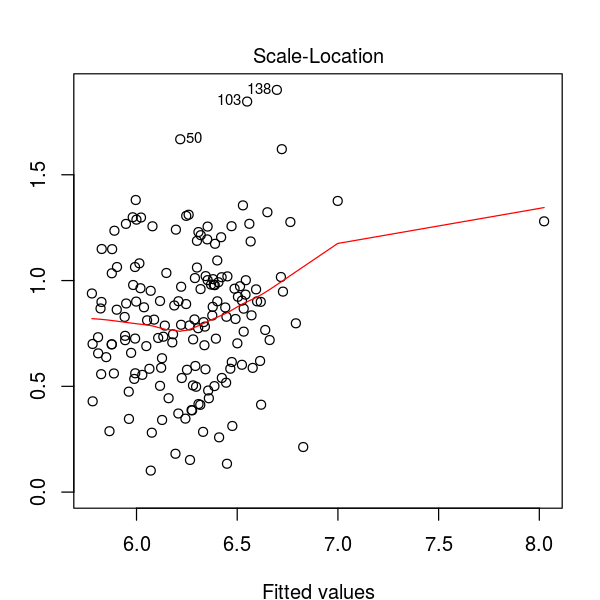

In [32]:
options(repr.plot.width=5, repr.plot.height=5)
plot(gauges_ols, which=3)

## Scatterplot of Observed vs Modeled values

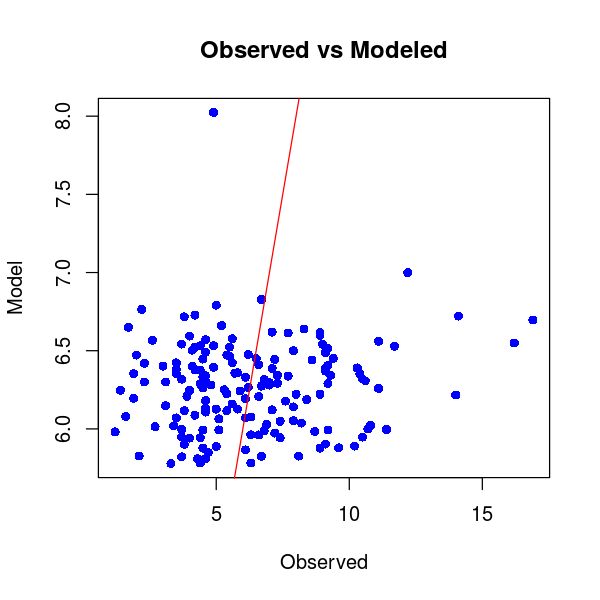

In [33]:
plot(gauges$obs_precip, gauges_ols$fitted.values, pch=16, col="Blue",
     xlab="Observed", ylab="Model", main="Observed vs Modeled")
abline(lm(gauges$obs_precip~gauges_ols$fitted.values), col="Red")

### Check spatial distribution of residuals

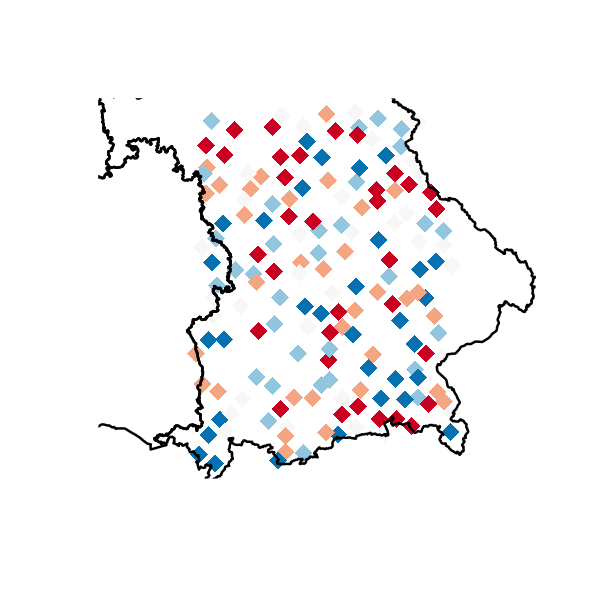

In [34]:
gauges_resids<-residuals(gauges_ols)
clrs <- brewer.pal(5, "RdBu")
gauges_resids_sp <- SpatialPointsDataFrame(data.frame(gauges_resids), 
                                           coords=xy_coords, 
                                           proj4string = proj_wgs84)
plot(gauges_resids_sp, cuts=cut(gauges_resids_sp$gauges_resids, breaks=5), 
     col=clrs, pch=18, cex=2)
plot(gadm_1, fill=F, border='black', lwd=2, add=T)

### Check for Normal Distribution of Residuals

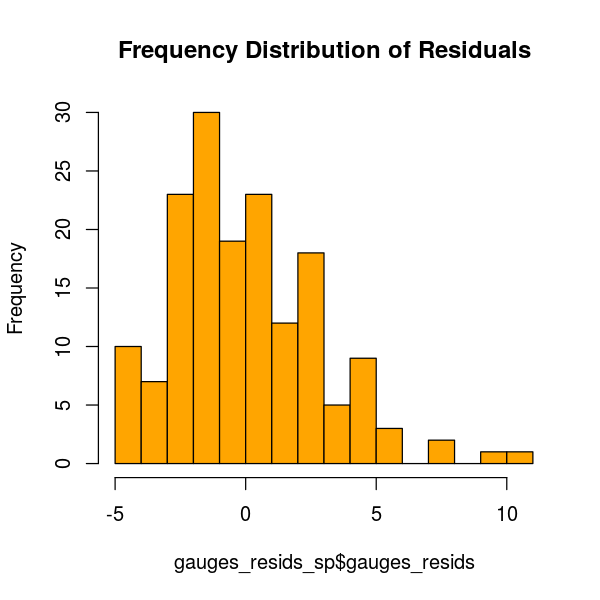

In [35]:
options(repr.plot.width=5, repr.plot.height=5)
hist(gauges_resids_sp$gauges_resids, col="orange", 
     breaks=12, main="Frequency Distribution of Residuals")

# Geographically Weighted Regression
### First get bandwidth  (static, not adaptive)

In [36]:
bw <- gwr.sel(obs_precip ~ elevation + aspect, 
              data = gauges, longlat=T)
print(bw)

Bandwidth: 136.0961 CV score: 1324.844 
Bandwidth: 219.9883 CV score: 1363.336 
Bandwidth: 84.24792 CV score: 1252.414 
Bandwidth: 52.20395 CV score: 1095.426 
Bandwidth: 32.39969 CV score: 817.1725 
Bandwidth: 20.15999 CV score: 869.5325 
Bandwidth: 30.01947 CV score: 762.9342 
Bandwidth: 27.05904 CV score: 700.3613 
Bandwidth: 24.42383 CV score: 669.5887 
Bandwidth: 22.28736 CV score: 697.3152 
Bandwidth: 24.61142 CV score: 670.2182 
Bandwidth: 24.2789 CV score: 669.34 
Bandwidth: 23.5182 CV score: 672.0796 
Bandwidth: 24.17741 CV score: 669.2977 
Bandwidth: 24.18857 CV score: 669.2968 
Bandwidth: 24.18998 CV score: 669.2968 
Bandwidth: 24.18988 CV score: 669.2968 
Bandwidth: 24.18992 CV score: 669.2968 
Bandwidth: 24.18984 CV score: 669.2968 
Bandwidth: 24.18988 CV score: 669.2968 
[1] 24.18988


### Run GWR

In [37]:
gauges_gwr <- gwr(obs_precip ~ elevation + aspect, 
                  data = gauges, longlat=T, bandwidth=bw, se.fit=T, hatmatrix=T)
str(gauges_gwr$SDF)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	163 obs. of  15 variables:
  .. ..$ sum.w             : num [1:163] 9.41 11.66 9.69 10.99 10.81 ...
  .. ..$ (Intercept)       : num [1:163] 0.226 3.146 15.605 5.045 2.67 ...
  .. ..$ elevation         : num [1:163] 0.01642 0.0056 -0.01451 0.00177 0.00303 ...
  .. ..$ aspect            : num [1:163] 9.48e-03 5.02e-03 6.63e-04 8.12e-05 7.62e-04 ...
  .. ..$ (Intercept)_se    : num [1:163] 1.5 1.59 2.01 1.58 1.07 ...
  .. ..$ elevation_se      : num [1:163] 0.00296 0.00309 0.00383 0.00304 0.00167 ...
  .. ..$ aspect_se         : num [1:163] 0.00309 0.00301 0.00296 0.00303 0.00326 ...
  .. ..$ gwr.e             : num [1:163] 2.0823 0.2205 0.0879 -0.1489 -0.5329 ...
  .. ..$ pred              : num [1:163] 9.62 6.38 8.31 5.75 4.33 ...
  .. ..$ pred.se           : num [1:163] 0.612 0.417 0.343 0.53 0.39 ...
  .. ..$ localR2           : num [1:163] 0.735 0.661 0.774 0.428 0.747 ...
  .. ..$ (Int

### What R-sqared values?

In [38]:
print(head(gauges_gwr$SDF@data$localR2, 60))

 [1] 0.7351504 0.6608426 0.7737640 0.4280060 0.7468303 0.6315979 0.7463714
 [8] 0.5503977 0.8499997 0.4198450 0.6930777 0.5431852 0.7422309 0.6968346
[15] 0.7309433 0.7006416 0.1080908 0.8149698 0.5597192 0.6040223 0.4835735
[22] 0.2114022 0.7192695 0.3614159 0.8696666 0.6404009 0.7653134 0.4150435
[29] 0.7728028 0.8202065 0.6542396 0.7477287 0.5542004 0.3533030 0.3379778
[36] 0.6509329 0.4937083 0.5750137 0.7370461 0.5619279 0.6090112 0.7971840
[43] 0.5577758 0.7485048 0.5066784 0.5821858 0.5366796 0.7982398 0.7084503
[50] 0.5520165 0.7653583 0.8905476 0.5269602 0.4892573 0.6684432 0.2840509
[57] 0.7170215 0.5171692 0.5067790 0.7776044


### Plot modeled precipitation rates

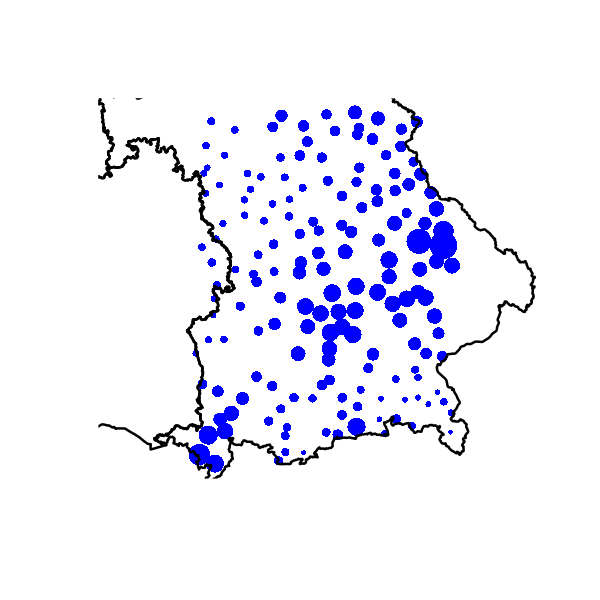

In [39]:
gauge_results <- as.data.frame(gauges_gwr$SDF)
gauge_results <- SpatialPointsDataFrame(gauge_results, 
                                       coords=xy_coords, 
                                       proj4string = proj_wgs84)
# Plot predicted precipitation rate
plot(gauge_results, pch=16, col="Blue", cex=gauge_results$pred/5)
plot(gadm_1, fill=F, border='black', lwd=2, add=T)

<img src='bavaria_gauges.png' width=600 height=600>

### Plot overall standard error

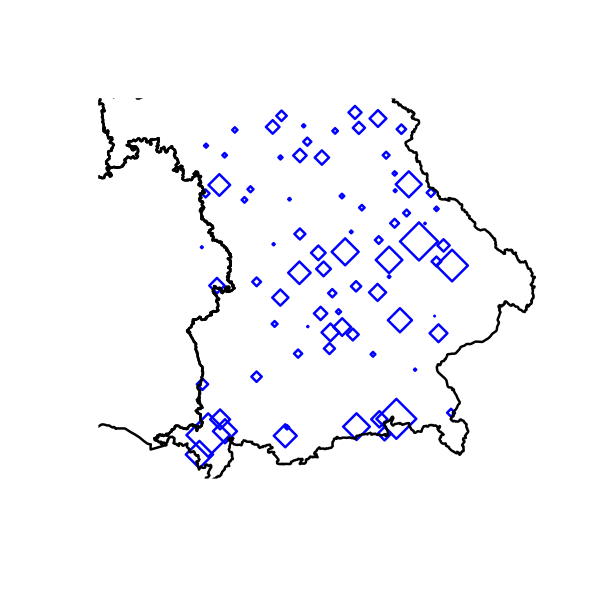

In [40]:
plot(gauge_results, pch=5, col="blue", cex=gauge_results$gwr.e, lwd=2)
plot(gadm_1, fill=F, border='black', lwd=2, add=T)

### Plot  coefficients for each independent variable

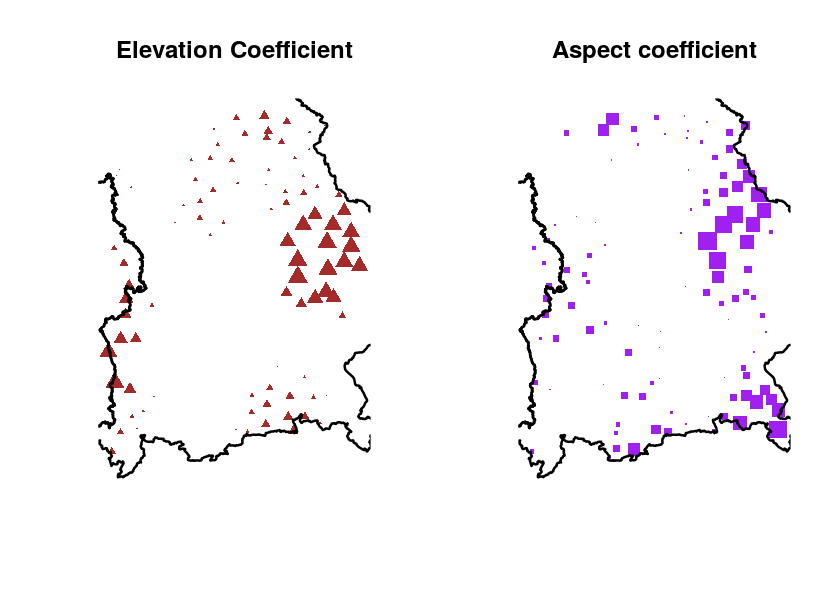

In [41]:
par(mfrow=c(1,2))
options(repr.plot.width=7, repr.plot.height=5)
plot(gauge_results, pch=17, col="brown", cex=gauge_results$elevation*100,
     main="Elevation Coefficient")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)
plot(gauge_results, pch=15, col="purple", cex=gauge_results$aspect*200,
     main="Aspect coefficient")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)

### Calculate and plot t-values for each coefficient
Matthews, S.A., Yang, T.-C., 2012. Mapping the results of local statistics: Using geographically weighted regression. Demographic Research 26, 151–166. doi:10.4054/DemRes.2012.26.6


In [42]:
# t-value = coefficient / standard error
elev_t <- as.data.frame(gauge_results$elevation / gauge_results$elevation_se)
colnames(elev_t) <- "t.value"
elev_t <- SpatialPointsDataFrame(elev_t, coords=xy_coords, 
                                proj4string = proj_wgs84)
aspect_t <- as.data.frame(gauge_results$aspect / gauge_results$aspect_se)
colnames(aspect_t) <- "t.value"
aspect_t <- SpatialPointsDataFrame(aspect_t, coords=xy_coords,
                                  proj4string = proj_wgs84)

In [43]:
# Set up colors for t-values
clrs2 <- rep("xx", nrow(elev_t@data))
clrs2[elev_t$t.value <= -2] <- "red" 
clrs2[(elev_t$t.value > -2) & (elev_t$t.value <= -1)] <- "orange"
clrs2[(elev_t$t.value > -1) & (elev_t$t.value <= 1)] <- "green"
clrs2[(elev_t$t.value > 1) & (elev_t$t.value <= 2)] <- "orange"
clrs2[elev_t$t.value > 2] <- "red" 

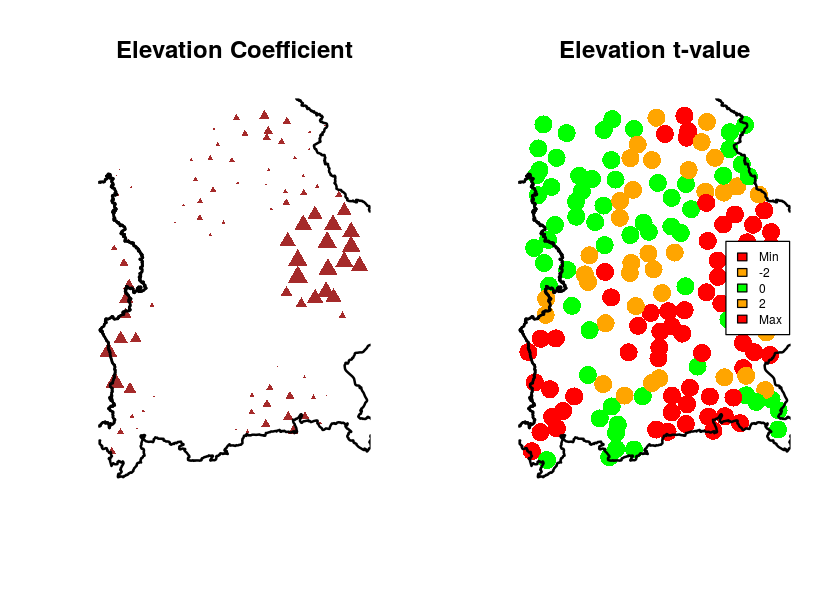

In [44]:

# Plot both coefficients and t-values side by side
par(mfrow=c(1,2))
plot(gauge_results, pch=17, col="brown", cex=gauge_results$elevation*100,
     main="Elevation Coefficient")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)
plot(elev_t, pch=16, col=clrs2, cex=2, main="Elevation t-value")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)
legend("right", legend=c("Min","-2","0","2","Max"), 
       fill=c("red","orange","green","orange","red"), cex=0.6 )

In [45]:
clrs2[aspect_t$t.value <= -2] <- "red" 
clrs2[(aspect_t$t.value > -2) & (aspect_t$t.value <= -1)] <- "orange"
clrs2[(aspect_t$t.value > -1) & (aspect_t$t.value <= 1)] <- "green"
clrs2[(aspect_t$t.value > 1) & (aspect_t$t.value <= 2)] <- "orange"
clrs2[aspect_t$t.value > 2] <- "red" 

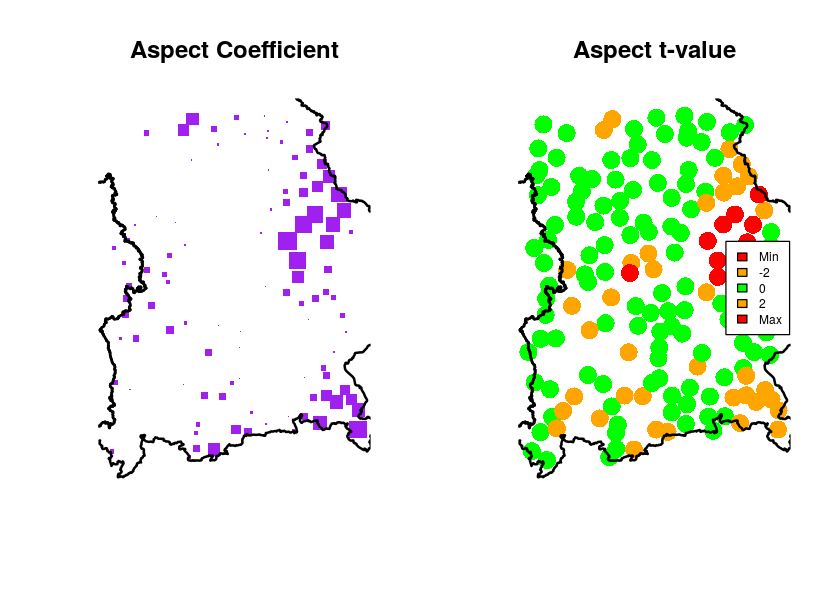

In [46]:
opar <- par(mfrow=c(1,2))
plot(gauge_results, pch=15, col="purple", cex=gauge_results$aspect*200,
     main="Aspect Coefficient")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)
plot(aspect_t, pch=16, col=clrs2, cex=2, main="Aspect t-value")
plot(gadm_1, fill=F, border='black', lwd=2, add=T)
legend("right", legend=c("Min","-2","0","2","Max"), 
       fill=c("red","orange","green","orange","red"), cex=0.6 )